# CS2-MPC

In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['font.family'] = "Helvetica"
matplotlib.rcParams['font.size'] = 20

In [2]:
%rm -rf ANN_for_MPC_pretraining
! git clone https://github.com/panos108/ANN_for_MPC_pretraining.git
! pip install casadi
import casadi

Cloning into 'ANN_for_MPC_pretraining'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 108 (delta 62), reused 67 (delta 30), pack-reused 0
Receiving objects: 100% (108/108), 130.96 KiB | 7.70 MiB/s, done.
Resolving deltas: 100% (62/62), done.


Define Case Study

In [3]:
# GP NMPC problem setup
import numpy as np
from casadi import *

# DETERMINISTIC MODEL
class Bio_reactor:

    def specifications(self):
        ''' Specify Problem parameters '''
        tf              = 4.       # final time
        nk              = 10.      # sampling points
        dt              = tf/nk
        x0              = np.array([0., 0., 0., 290., 100.])
        Lsolver         = 'mumps'  #'ma97'  # Linear solver
        c_code          = False    # c_code
        shrinking_horizon = True

        return dt, x0, Lsolver, c_code, shrinking_horizon

    def DAE_system(self):
        # Define vectors with names of states
        states     = ['CA', 'CB', 'CC', 'T', 'Vol']
        nd         = len(states)
        xd         = SX.sym('xd',nd)
        for i in range(nd):
            globals()[states[i]] = xd[i]

        # Define vectors with names of algebraic variables
        algebraics = []
        na         = len(algebraics)
        xa         = SX.sym('xa',na)
        for i in range(na):
            globals()[algebraics[i]] = xa[i]

        set_points = []
        n_ref      = len(set_points)
        x_ref      = SX.sym('x_ref',n_ref)
        for i in range(n_ref):
            globals()[set_points[i]] = x_ref[i]

        # Define vectors with banes of input variables
        inputs     = ['u_F','u_T']
        nu         = len(inputs)
        u          = SX.sym("u",nu)
        for i in range(nu):
            globals()[inputs[i]] = u[i]

        # Define model parameter names and values
        modpar    = ['CpA','CpB','CpC','CpH2SO4','T0','HRA','HRB','E1A','E2A','A1',\
                 'Tr1','Tr2','CA0','A2','UA','N0H2S04']
        modparval = [30.,60.,20.,35.,305.,-6500.,8000.,9500./1.987,7000./1.987,\
                 1.25,420.,400.,4.,0.08,4.5,100.]

        nmp       = len(modpar)
        uncertainty = []#SX.sym('uncp', nmp)
        for i in range(nmp):
            globals()[modpar[i]] = SX(modparval[i])# + uncertainty[i])

        # Additive measurement noise
    #    Sigma_v  = [400.,1e5,1e-2]*diag(np.ones(nd))*1e-6

        # Additive disturbance noise
    #    Sigma_w  = [400.,1e5,1e-2]*diag(np.ones(nd))*1e-6

        # Initial additive disturbance noise
    #    Sigma_w0 = [1.,150.**2,0.]*diag(np.ones(nd))*1e-3
        

        # Declare algebraic equations
        Aeq = []
        r1 = A1*exp(E1A*(1./Tr1-1./T))
        r2 = A2*exp(E2A*(1./Tr2-1./T))
        
        # Declare ODE equations (use notation as defined above)
        dCA   = -r1*CA + (CA0-CA)*(u_F/Vol)
        dCB   =  r1*CA/2 - r2*CB - CB*(u_F/Vol)
        dCC   =  3*r2*CB - CC*(u_F/Vol)
        dT    =  (UA*10.**4*(u_T-T) - CA0*u_F*CpA*(T-T0) + (HRA*(-r1*CA)+HRB*(-r2*CB\
                    ))*Vol)/((CA*CpA+CpB*CB+CpC*CC)*Vol + N0H2S04*CpH2SO4)
        dVol  =  u_F

              # * (tanh(1000*(500. - n))+1)/2 * (tanh(1000*(x - 10.000))+1)/2# * (sign(499.9999 - n)+1)/2 * (sign(x - 10.0001)+1)/2

        ODEeq =  [dCA, dCB, dCC, dT, dVol]


        # Define objective to be minimized
        t     = SX.sym('t')
        Obj_M = Function('mayer', [xd, x_ref, u], [-CC*Vol])  # Mayer term
        Obj_L = Function('lagrange', [xd, x_ref, u], [0.])  # Lagrange term
        Obj_D = Function('Discrete', [xd, x_ref, u], [0.])  # Lagrange term

        R           = np.diagflat([3.125e-8, 3.125e-006])    # Weighting of control penality

        # Define control bounds
        u_min = np.array([0.  , 270.])
        u_max = np.array([250., 500.])
        x_min = np.array([0.]*nd)
        x_max = np.array([np.inf]*nd)
        # Define constraint functions g(x) <= 0
        gequation = vertcat(T - 420., Vol - 800.)
        ng = SX.size(gequation)[0]
        gfcn = Function('gfcn', [xd, xa, u], [gequation])

        return xd, xa, u, uncertainty, ODEeq, Aeq, u_min, u_max, x_min, x_max, states,\
               algebraics, inputs, nd, na, nu, n_ref, nmp, modparval, ng, gfcn, Obj_M, Obj_L, Obj_D, R


    def integrator_model(self):
        """
        This function constructs the integrator to be suitable with casadi environment, for the equations of the model
        and the objective function with variable time step.
         inputs: NaN
         outputs: F: Function([x, u, dt]--> [xf, obj])
        """

        xd, xa, u, uncertainty, ODEeq, Aeq, u_min, u_max, x_min, x_max, states, \
        algebraics, inputs, nd, na, nu, n_ref, nmp, modparval, ng, gfcn, Obj_M, Obj_L, Obj_D, R = self.DAE_system()

        dae = {'x': vertcat(xd), 'z': vertcat(xa), 'p': vertcat(u, uncertainty),
               'ode': vertcat(*ODEeq), 'alg': vertcat(*Aeq)}
        opts = {'tf': 4./10.}  # interval length
        F = integrator('F', 'idas', dae, opts)

        return F

# STOCHASTIC MODEL
class Bio_reactor_unc:

    def specifications(self):
        ''' Specify Problem parameters '''
        tf              = 4.       # final time
        nk              = 10.      # sampling points
        dt              = tf/nk
        x0              = np.array([0., 0., 0., 290., 100.])
        Lsolver         = 'mumps'  #'ma97'  # Linear solver
        c_code          = False    # c_code
        shrinking_horizon = True

        return dt, x0, Lsolver, c_code, shrinking_horizon

    def DAE_system(self):
        # Define vectors with names of states
        states     = ['CA', 'CB', 'CC', 'T', 'Vol']
        nd         = len(states)
        xd         = SX.sym('xd',nd)
        for i in range(nd):
            globals()[states[i]] = xd[i]

        # Define vectors with names of algebraic variables
        algebraics = []
        na         = len(algebraics)
        xa         = SX.sym('xa',na)
        for i in range(na):
            globals()[algebraics[i]] = xa[i]

        set_points = []
        n_ref      = len(set_points)
        x_ref      = SX.sym('x_ref',n_ref)
        for i in range(n_ref):
            globals()[set_points[i]] = x_ref[i]

        # Define vectors with banes of input variables
        inputs     = ['u_F','u_T']
        nu         = len(inputs)
        u          = SX.sym("u",nu)
        for i in range(nu):
            globals()[inputs[i]] = u[i]

        # Define model parameter names and values
        modpar    = ['CpA','CpB','CpC','CpH2SO4','T0','HRA','HRB','E1A','E2A','A1',\
                 'Tr1','Tr2','CA0','A2','UA','N0H2S04']
        modparval = [30.,60.,20.,35.,305.,-6500.,8000.,9500./1.987,7000./1.987,\
                 1.25,420.,400.,4.,0.08,4.5,100.]

        nmp       = len(modpar)
        uncertainty = SX.sym('uncp', nmp)
        for i in range(nmp):
            globals()[modpar[i]] = SX(modparval[i] + uncertainty[i])

        # Additive measurement noise
    #    Sigma_v  = [400.,1e5,1e-2]*diag(np.ones(nd))*1e-6

        # Additive disturbance noise
    #    Sigma_w  = [400.,1e5,1e-2]*diag(np.ones(nd))*1e-6

        # Initial additive disturbance noise
    #    Sigma_w0 = [1.,150.**2,0.]*diag(np.ones(nd))*1e-3
        

        # Declare algebraic equations
        Aeq = []
        r1 = A1*exp(E1A*(1./Tr1-1./T))
        r2 = A2*exp(E2A*(1./Tr2-1./T))
        
        # Declare ODE equations (use notation as defined above)
        dCA   = -r1*CA + (CA0-CA)*(u_F/Vol)
        dCB   =  r1*CA/2 - r2*CB - CB*(u_F/Vol)
        dCC   =  3*r2*CB - CC*(u_F/Vol)
        dT    =  (UA*10.**4*(u_T-T) - CA0*u_F*CpA*(T-T0) + (HRA*(-r1*CA)+HRB*(-r2*CB\
                    ))*Vol)/((CA*CpA+CpB*CB+CpC*CC)*Vol + N0H2S04*CpH2SO4)
        dVol  =  u_F

              # * (tanh(1000*(500. - n))+1)/2 * (tanh(1000*(x - 10.000))+1)/2# * (sign(499.9999 - n)+1)/2 * (sign(x - 10.0001)+1)/2

        ODEeq =  [dCA, dCB, dCC, dT, dVol]


        # Define objective to be minimized
        t     = SX.sym('t')
        Obj_M = Function('mayer', [xd, x_ref, u], [-CC*Vol])  # Mayer term
        Obj_L = Function('lagrange', [xd, x_ref, u], [0.])  # Lagrange term
        Obj_D = Function('Discrete', [xd, x_ref, u], [0.])  # Lagrange term

        R           = np.diagflat([3.125e-8, 3.125e-006])    # Weighting of control penality

        # Define control bounds
        u_min = np.array([0.  , 270.])
        u_max = np.array([250., 500.])
        x_min = np.array([0.]*nd)
        x_max = np.array([np.inf]*nd)
        # Define constraint functions g(x) <= 0
        gequation = vertcat(T - 420., Vol - 800.)
        ng = SX.size(gequation)[0]
        gfcn = Function('gfcn', [xd, xa, u], [gequation])

        return xd, xa, u, uncertainty, ODEeq, Aeq, u_min, u_max, x_min, x_max, states,\
               algebraics, inputs, nd, na, nu, n_ref, nmp, modparval, ng, gfcn, Obj_M, Obj_L, Obj_D, R


    def integrator_model(self):
        """
        This function constructs the integrator to be suitable with casadi environment, for the equations of the model
        and the objective function with variable time step.
         inputs: NaN
         outputs: F: Function([x, u, dt]--> [xf, obj])
        """

        xd, xa, u, uncertainty, ODEeq, Aeq, u_min, u_max, x_min, x_max, states, \
        algebraics, inputs, nd, na, nu, n_ref, nmp, modparval, ng, gfcn, Obj_M, Obj_L, Obj_D, R = self.DAE_system()

        dae = {'x': vertcat(xd), 'z': vertcat(xa), 'p': vertcat(u, uncertainty),
               'ode': vertcat(*ODEeq), 'alg': vertcat(*Aeq)}
        opts = {'tf': 4./10.}  # interval length
        F = integrator('F', 'idas', dae, opts)

        return F

Bioreactor with shrinking Horizon

In [4]:
# Define covariance matrix of params
# mean = [4.,0.08,4.5,100.]
variance = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 1.6e-4, 0, 5.]) # From IFAC paper: Economic Stochastic Model Predictive ControlUsing the Unscented Kalman Filter
Cov = np.diag(variance) 
Cov

array([[0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+

CasADi - 2021-03-30 22:40:46 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 187, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:40:46 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 222, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:40:46 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 152, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:40:46 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 152, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:40:46 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 152, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:40:46 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 180, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:40:46 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 

CasADi - 2021-03-30 22:40:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 145, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:40:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 145, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:40:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 145, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:40:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 145, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:40:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 152, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:40:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 152, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:40:50 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 

CasADi - 2021-03-30 22:40:53 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 75, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:40:53 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 47, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:40:53 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 47, col 0).") [.../casadi/core/oracle_function.cpp:265]


Opt failed


CasADi - 2021-03-30 22:40:55 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 222, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:40:55 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 222, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:40:55 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 222, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:40:55 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 145, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:40:55 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 152, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:40:55 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 152, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:40:55 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 

Opt failed


CasADi - 2021-03-30 22:41:00 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 110, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:41:00 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 110, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:41:00 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 110, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:41:00 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 145, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:41:00 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 152, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:41:00 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 152, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:41:01 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 

CasADi - 2021-03-30 22:41:06 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 215, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:41:06 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 215, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:41:06 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 215, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:41:06 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 215, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:41:06 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 250, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:41:06 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 229, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-30 22:41:06 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 

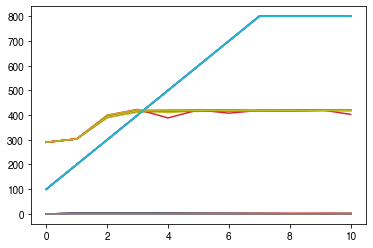

In [6]:
# RUN ONE EPISODE
from casadi import *
import numpy as np
from ANN_for_MPC_pretraining.utilities import MPC
import matplotlib.pyplot as plt

episode_pool = []
for k in range(10):
    dp = np.random.multivariate_normal([0]*16, Cov)

    System     = Bio_reactor
    System_unc = Bio_reactor_unc
    N =10 # This is the total steps
    #Initialize system
    Sys = System_unc()
    dt, x0, _, _, _ = Sys.specifications()
    F = Sys.integrator_model()
    # Construct MPC
    MPC_ = MPC(System, horizon=N, penalize_u=False) 
    # Define system

      # Initialize Matrices
    his_x = np.zeros([1000, len(x0)])
    his_u = np.zeros([1000, 2])
    t     = 0.
    u_apply = np.array([0.])

    for i in range(10):
        his_x[i] = x0
        u_opt, x_opt, w_opt = MPC_.solve_MPC(x=x0, t=t) # Deterministic Model
        
        u_apply  = np.array(u_opt)[:,0]
        his_u[i] = u_apply
        x1 = F(x0=x0, p=vertcat(u_apply, dp))           # Real System
        x0 = np.array(x1['xf']).reshape((-1,))
        t += dt
        if i == 9:
            his_x[i+1] = x0
            his_u[i+1] = u_apply
    plt.plot(his_x[:N+1])

    CA_list = his_x[:,0][:11]
    CB_list = his_x[:,1][:11]
    CC_list = his_x[:,2][:11]
    T_list = his_x[:,3][:11]
    Vol_list = his_x[:,4][:11]
    u_F_list = his_u[:,0][:11]
    u_T_list  = his_u[:,1][:11]
    t_list = np.arange(0,4.4, 0.4)
    episode = []
    for i in range(len(CA_list)):
        state   = [CA_list[i], CB_list[i], CC_list[i], T_list[i], Vol_list[i], t_list[i]]
        control = [u_F_list[i], u_T_list[i]]
        if i == range(len(CC_list))[-1]:
            reward = CC_list[i]*Vol_list[i]
        else:
            reward = 0
        episode += [[state, control, reward]]
    episode_pool += [episode]
# episode

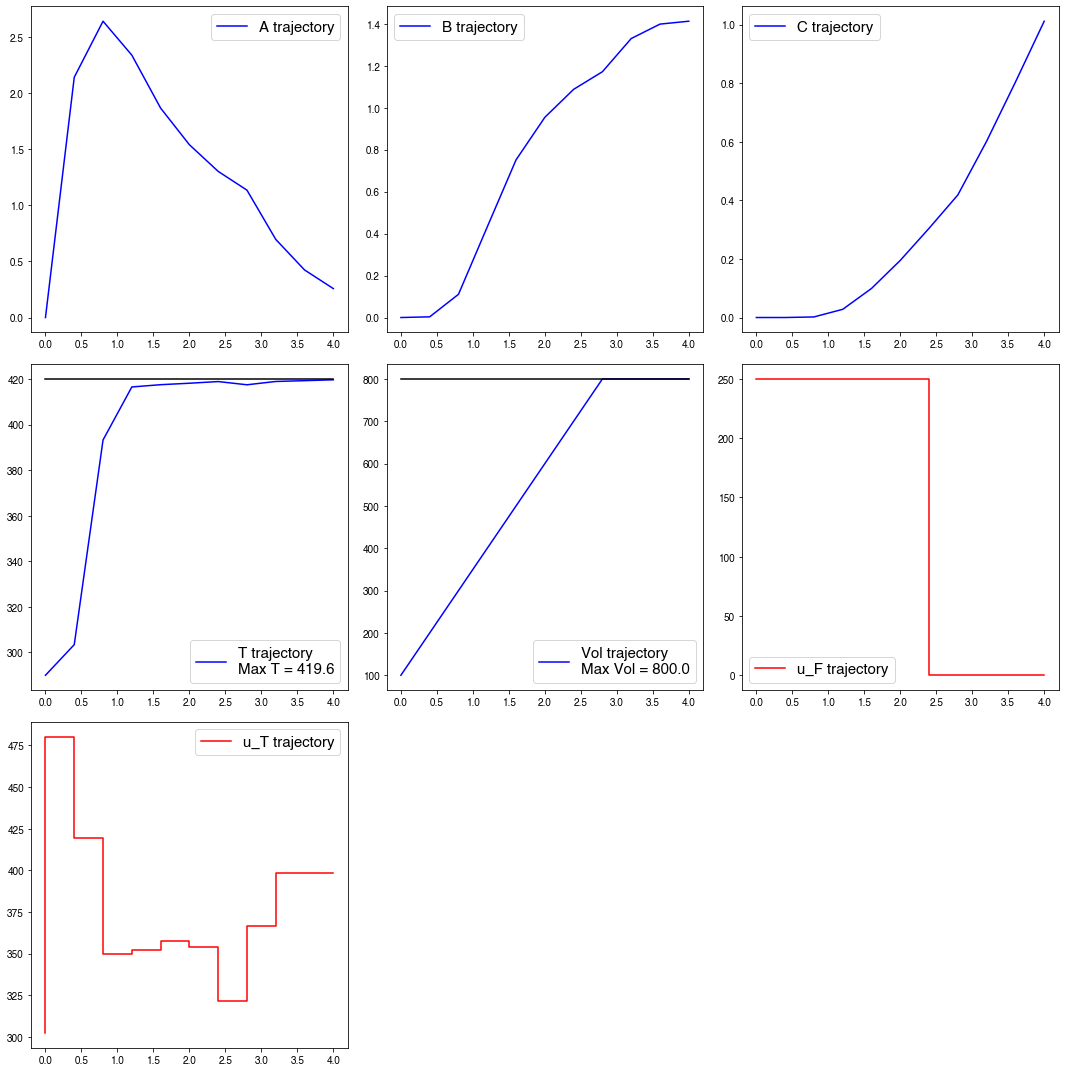

Score: 809.2712258658983


In [9]:
# Some really impressive result!
tf = 0.4
plot_episode(episode)

No handles with labels found to put in legend.
<ipython-input-8-086c90c02849>:142: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,3,1)
No handles with labels found to put in legend.
<ipython-input-8-086c90c02849>:146: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,3,2)
<ipython-input-8-086c90c02849>:149: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently r

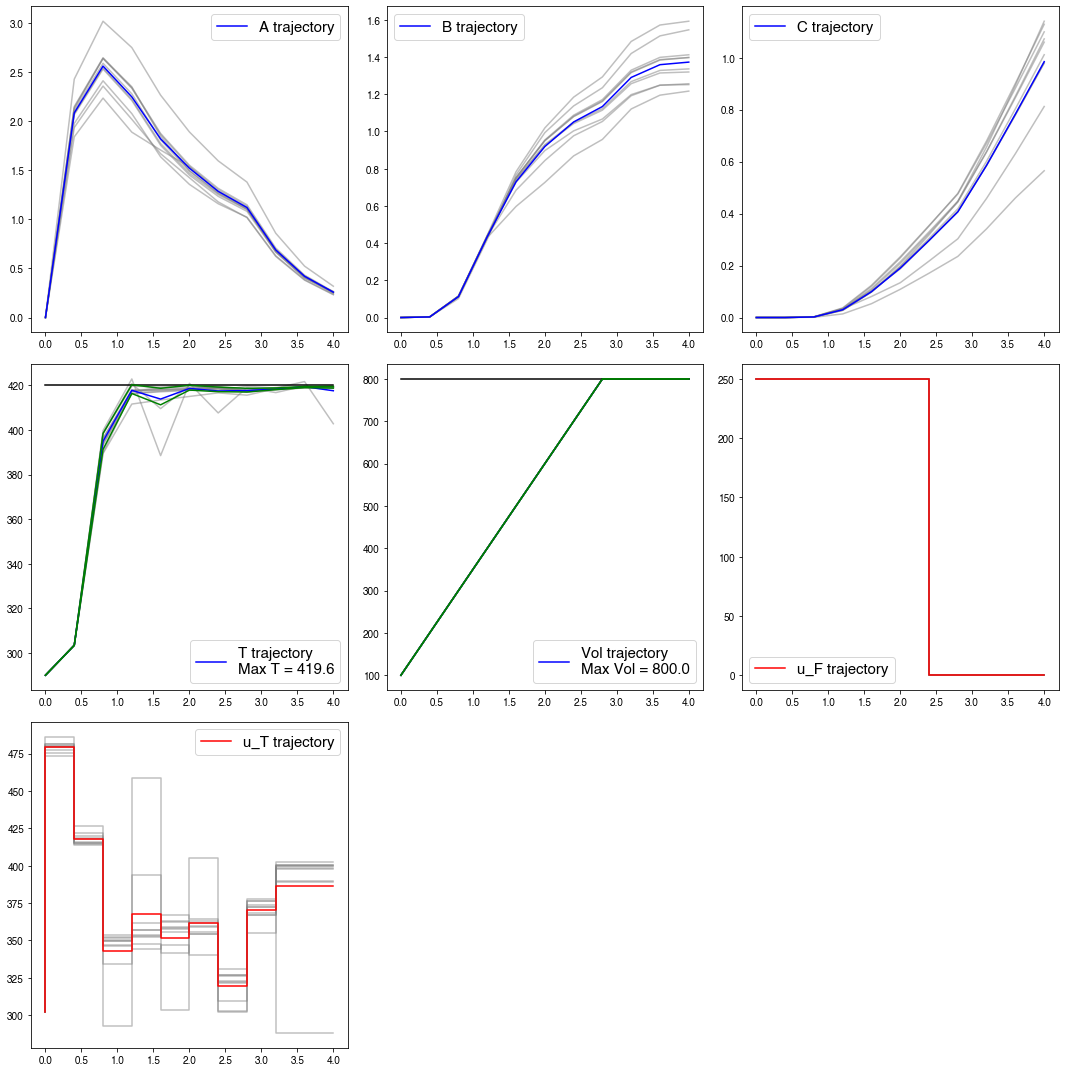

Score: 787.964017236473
total no. of episodes: 10
episodes that violate g1: 3
episodes that violate g2: 0
episodes that violate both g1 and g2: 0
episodes that violate either g1 or g2: 3


In [10]:
plot_episode_pool(episode_pool)

Opt failed
Opt failed
Opt failed
Opt failed
Opt failed
Opt failed
Opt failed
Opt failed
Opt failed
Opt failed
Opt failed
Opt failed
Opt failed
Opt failed
Opt failed
Opt failed
Opt failed
Opt failed


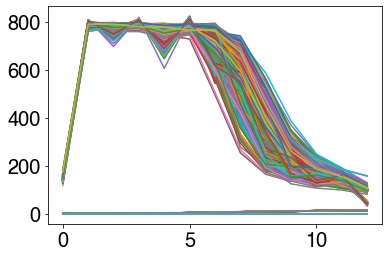

In [153]:
# GENERATE EPISODE POOL
from casadi import *
import numpy as np
from ANN_for_MPC_pretraining.utilities import MPC
import matplotlib.pyplot as plt

episode_pool = []
for k in range(400):
    dp = np.random.multivariate_normal([0]*11, Cov)

    System     = Bio_reactor
    System_unc = Bio_reactor_unc
    N =12 # This is the total steps
    #Initialize system
    Sys = System_unc()
    dt, x0, _, _, _ = Sys.specifications()
    F = Sys.integrator_model()
    # Construct MPC
    MPC_ = MPC(System, horizon=N, penalize_u=False) 
    # Define system

      # Initialize Matrices
    his_x = np.zeros([1000, len(x0)])
    his_u = np.zeros([1000, 2])
    t     = 0.
    u_apply = np.array([0.])

    for i in range(12):
        his_x[i] = x0
        u_opt, x_opt, w_opt = MPC_.solve_MPC(x=x0, t=t) # Deterministic Model

        u_apply  = np.array(u_opt)[:,0]
        his_u[i] = u_apply
        x1 = F(x0=x0, p=vertcat(u_apply, dp))           # Real System
        x0 = np.array(x1['xf']).reshape((-1,))
        t += dt
        if i == 11:
            his_x[i+1] = x0
            his_u[i+1] = u_apply
    plt.plot(his_x[:N+1])

    Cx_list = his_x[:,0][:13]
    Cn_list = his_x[:,1][:13]
    Cq_list = his_x[:,2][:13]
    u_Fn_list = his_u[:,1][:13]
    u_L_list  = his_u[:,0][:13]
    t_list = np.arange(0,260, 20)
    episode = []
    for i in range(len(Cx_list)):
        state   = [Cx_list[i], Cn_list[i], Cq_list[i], t_list[i]]
        control = [u_Fn_list[i], u_L_list[i]]
        if i == range(len(Cx_list))[-1]:
            reward = Cq_list[i]
        else:
            reward = 0
        episode += [[state, control, reward]]
    episode_pool += [episode]

In [8]:
# DEFINE PLOTTING FUNCTIONS
def plot_episode(episode):
    '''Plots an episode and corresponding score'''
    CA_list  = []
    CB_list  = []
    CC_list  = []
    T_list   = []
    Vol_list = []
    t_list   = []
    u_F_list = []
    u_T_list = []
    reward_list = []
    t = 0
    for step in episode:
        [CA, CB, CC, T, Vol, t], [u_F, u_T], reward = step
        CA_list  += [CA]
        CB_list  += [CB]
        CC_list  += [CC]
        T_list   += [T]
        Vol_list += [Vol]
        t_list   += [t]
        u_F_list += [u_F]
        u_T_list += [u_T]
        reward_list += [reward]
        t += tf
    
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
#     fig, ax = plt.figure(figsize=(10,10))
    
    plt.subplot(3,3,1)
    plt.plot(t_list, CA_list, label = 'A trajectory', color = 'b')
    plt.legend(fontsize = 15)

    plt.subplot(3,3,2)
    plt.plot(t_list, CB_list, label = 'B trajectory', color = 'b')
    plt.legend(fontsize = 15)

    plt.subplot(3,3,3)
    plt.plot(t_list, CC_list, label = 'C trajectory', color = 'b')
    plt.legend(fontsize = 15)

    plt.subplot(3,3,4)
    plt.plot(t_list, T_list, label = 'T trajectory \nMax T = %.1f' % max(T_list), color = 'b')
    plt.plot(t_list, [420]*len(t_list), color = 'black')
    plt.legend(fontsize = 15)

    plt.subplot(3,3,5)
    plt.plot(t_list, Vol_list, label = 'Vol trajectory \nMax Vol = %.1f' % max(Vol_list), color = 'b')
    plt.plot(t_list, [800]*len(t_list), color = 'black')
    plt.legend(fontsize = 15)
    
    plt.subplot(3,3,6)
    plt.step(t_list, u_F_list, label = 'u_F trajectory', color = 'r')
    plt.legend(fontsize = 15)
    
    plt.subplot(3,3,7)
    plt.step(t_list, u_T_list, label = 'u_T trajectory', color = 'r')
    plt.legend(fontsize = 15)
    
    fig.tight_layout()
    fig.delaxes(ax[2][1]) # delete last 8th plot (empty)
    fig.delaxes(ax[2][2]) # delete last 9th plot (empty)
    plt.show()
    print('Score:', CC_list[-1]*Vol_list[-1])

def violate_g1(T):
    if T > 420:
        return True
    else:
        return False

def violate_g2(Vol):
    if Vol > 800:
        return True
    else:
        return False    

def plot_episode_pool(episode_pool):
    '''Plots an episode pool (n number of episodes) and corresponding score'''
    episodes_g1_violated = 0 # No. of episodes that violate g1
    episodes_g2_violated = 0 # No. of episodes that violate g1
    episodes_g1g2_both_violated = 0 # No. of episodes that violate both
    episodes_g1g2_only_one_violated = 0 # No. of episodes that violate either g1 and g2
    total_score = 0
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
    CA_pool  = []
    CB_pool  = []
    CC_pool  = []
    T_pool   = []
    Vol_pool = []
    u_F_pool = []
    u_T_pool = []
    
    for idx in range(len(episode_pool)): # Idx refers to nth episode in episode pool
        episode = episode_pool[idx]
        CA_list  = []
        CB_list  = []
        CC_list  = []
        T_list   = []
        Vol_list = []
        t_list   = []
        u_F_list = []
        u_T_list = []
        reward_list = []
        t = 0
        for step in episode:
            [CA, CB, CC, T, Vol, t], [u_F, u_T], reward = step
            CA_list  += [CA]
            CB_list  += [CB]
            CC_list  += [CC]
            T_list   += [T]
            Vol_list += [Vol]
            t_list   += [t]
            u_F_list += [u_F]
            u_T_list += [u_T]
            reward_list += [reward]
            t += tf
    #     fig, ax = plt.figure(figsize=(10,10))
        
        # Add scores to total score
        score        = CC_list[-1]*Vol_list[-1]
        total_score += score
        
        # Count number of EPISODES that have violation
        if True in map(violate_g1, T_list):
            episodes_g1_violated += 1
        if True in map(violate_g2, Vol_list):
            episodes_g2_violated += 1
        if (True in map(violate_g1, T_list)) and (True in map(violate_g2, Vol_list)):
            episodes_g1g2_both_violated += 1
        if (True in map(violate_g1, T_list)) or (True in map(violate_g2, Vol_list)):
            episodes_g1g2_only_one_violated += 1
        
        CA_pool  += [CA_list]
        CB_pool  += [CB_list]
        CC_pool  += [CC_list]
        T_pool   += [T_list]
        Vol_pool += [Vol_list]
        u_F_pool += [u_F_list]
        u_T_pool += [u_T_list]
        
        plt.subplot(3,3,1)
        plt.plot(t_list, CA_list, color = 'grey', alpha = 0.5)
        plt.legend(fontsize = 15)

        plt.subplot(3,3,2)
        plt.plot(t_list, CB_list, color = 'grey', alpha = 0.5)

        plt.subplot(3,3,3)
        plt.plot(t_list, CC_list, color = 'grey', alpha = 0.5)

        plt.subplot(3,3,4)
        plt.plot(t_list, T_list, color = 'grey', alpha = 0.5)

        plt.subplot(3,3,5)
        plt.plot(t_list, Vol_list, color = 'grey', alpha = 0.5)

        plt.subplot(3,3,6)
        plt.step(t_list, u_F_list, color = 'grey', alpha = 0.5)

        plt.subplot(3,3,7)
        plt.step(t_list, u_T_list, color = 'grey', alpha = 0.5)
    
    CA_pool  = np.array(CA_pool)
    CB_pool  = np.array(CB_pool)
    CC_pool  = np.array(CC_pool)
    T_pool   = np.array(T_pool)
    Vol_pool = np.array(Vol_pool)
    u_F_pool = np.array(u_F_pool)
    u_T_pool = np.array(u_T_pool)
    
    # Take mean of all columns (all time steps)
    CA_avg_list  = CA_pool.mean(axis=0)
    CB_avg_list  = CB_pool.mean(axis=0)
    CC_avg_list  = CC_pool.mean(axis=0)
    T_avg_list   = T_pool.mean(axis=0)
    Vol_avg_list = Vol_pool.mean(axis=0)
    u_F_avg_list = u_F_pool.mean(axis=0)
    u_T_avg_list = u_T_pool.mean(axis=0)
    
    # Find +/- one STD of all columns
    T_std_upper = np.percentile(T_pool, 84, axis = 0)
    T_std_lower = np.percentile(T_pool, 16, axis = 0)
    
    Vol_std_upper = np.percentile(Vol_pool, 84, axis = 0)
    Vol_std_lower = np.percentile(Vol_pool, 16, axis = 0)
    
    plt.subplot(3,3,1)
    plt.plot(t_list, CA_avg_list, label = 'A trajectory', color = 'b')
    plt.legend(fontsize = 15)

    plt.subplot(3,3,2)
    plt.plot(t_list, CB_avg_list, label = 'B trajectory', color = 'b')
    plt.legend(fontsize = 15)

    plt.subplot(3,3,3)
    plt.plot(t_list, CC_avg_list, label = 'C trajectory', color = 'b')
    plt.legend(fontsize = 15)

    plt.subplot(3,3,4)
    plt.plot(t_list, T_avg_list, label = 'T trajectory \nMax T = %.1f' % max(T_list), color = 'b')
    plt.plot(t_list, [420]*len(t_list), color = 'black')
    plt.plot(t_list, T_std_upper, color = 'green')
    plt.plot(t_list, T_std_lower, color = 'green')
    plt.legend(fontsize = 15, loc = 'lower right')

    plt.subplot(3,3,5)
    plt.plot(t_list, Vol_avg_list, label = 'Vol trajectory \nMax Vol = %.1f' % max(Vol_list), color = 'b')
    plt.plot(t_list, [800]*len(t_list), color = 'black')
    plt.plot(t_list, Vol_std_upper, color = 'green')
    plt.plot(t_list, Vol_std_lower, color = 'green')
    plt.legend(fontsize = 15, loc = 'lower right')

    plt.subplot(3,3,6)
    plt.step(t_list, u_F_avg_list, label = 'u_F trajectory', color = 'r')
    plt.legend(fontsize = 15)

    plt.subplot(3,3,7)
    plt.step(t_list, u_T_avg_list, label = 'u_T trajectory', color = 'r')
    plt.legend(fontsize = 15)
    
    fig.tight_layout()
    fig.delaxes(ax[2][1]) # delete last 8th plot (empty)
    fig.delaxes(ax[2][2]) # delete last 9th plot (empty)
    plt.show()
    
    avg_score = total_score/len(episode_pool)
    print('Score:', avg_score)
    print('total no. of episodes:', len(episode_pool))
    print('episodes that violate g1:',episodes_g1_violated) 
    print('episodes that violate g2:',episodes_g2_violated)
    print('episodes that violate both g1 and g2:',episodes_g1g2_both_violated)
    print('episodes that violate either g1 or g2:',episodes_g1g2_only_one_violated)

In [37]:
# SAVING EPISODE POOL - JSON WORKS BUT NOT PICKLE BCOS NESTED LIST
import json
class NpEncoder(json.JSONEncoder): 
    def default(self, obj):
        if isinstance(obj, numpy.float64):
            return float(obj)
        if isinstance(obj, numpy.int):
            return float(obj)
# open output file for writing
# with open('./Data/CS2_episode_pool_MPC_noise', 'w') as f:
#     json.dump(episode_pool, f, cls=NpEncoder)
# open output file for reading
# with open('./Data/CS2_episode_pool_MPC_noise', 'r') as f:
#     episode_pool = json.load(f)

No handles with labels found to put in legend.
<ipython-input-19-086c90c02849>:142: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,3,1)
No handles with labels found to put in legend.
<ipython-input-19-086c90c02849>:146: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,3,2)
<ipython-input-19-086c90c02849>:149: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currentl

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

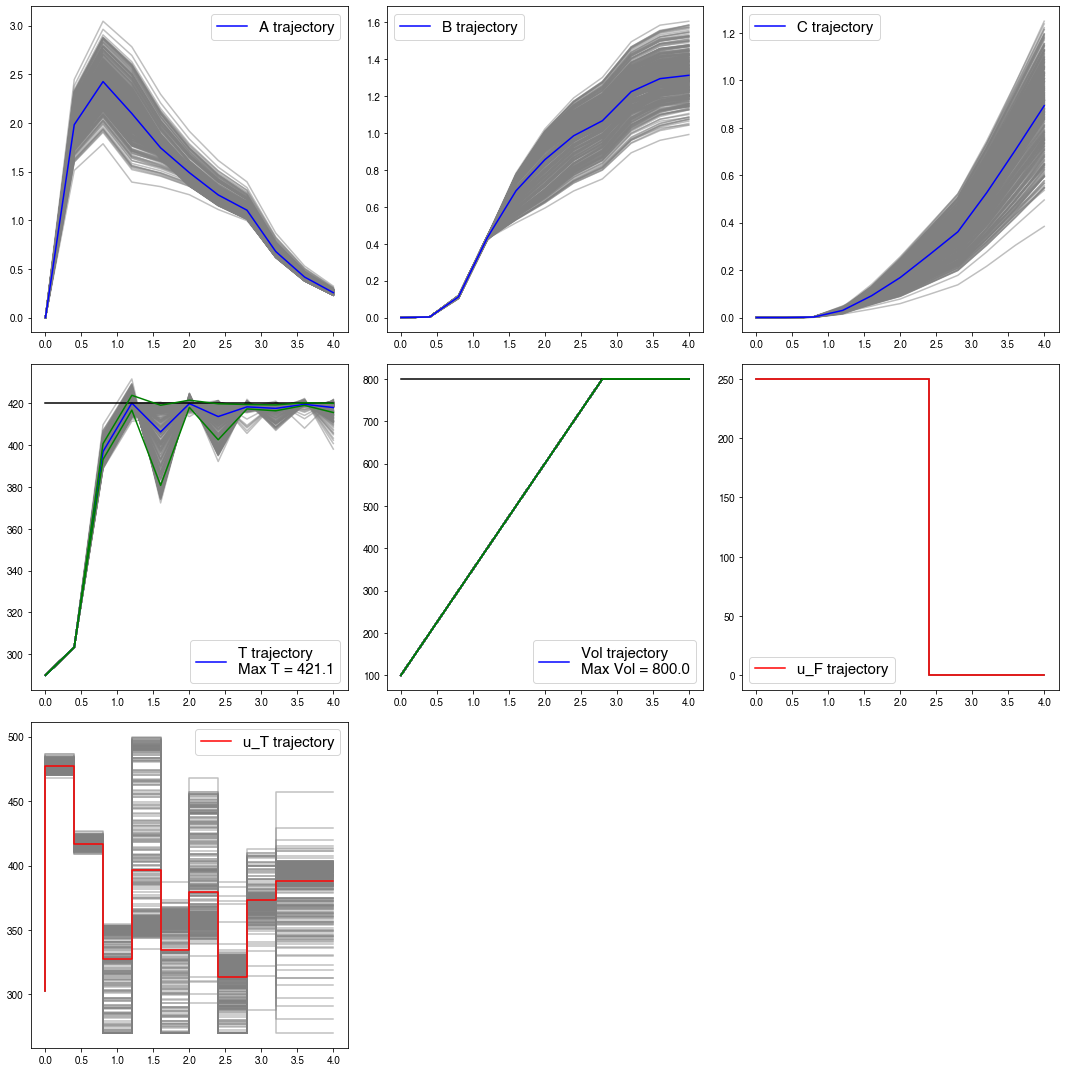

Score: 714.4723524030886
total no. of episodes: 400
episodes that violate g1: 265
episodes that violate g2: 22
episodes that violate both g1 and g2: 22
episodes that violate either g1 or g2: 265


In [38]:
plot_episode_pool(episode_pool)